# Notebook for LSTM VAE with cyclic annealing, word dropout and free bits

# Set up notebook

In [21]:
!nvidia-smi

Fri Jan  3 16:41:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    34W / 250W |   8153MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [22]:
!pip install sentencepiece

In [23]:
import sys
from google.colab import drive
drive.mount('/content/drive/')
#root_path = 'drive/My Drive/Colab_Notebooks/deeplearning/Sentence_VAE/'
#root_path = '/content/drive/My Drive/Sentence_VAE/'
root_path = '/content/drive/My Drive/Colab Notebooks/Sentence_VAE/'
sys.path.append(root_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Import modules

In [0]:
# import model
from modules.model import RNN_VAE, word_dropout

# import loss functions
from modules.loss_functions import ELBO_loss, ELBO_lAnneal, ELBO_cAnneal, ELBO_cAnnealFB, cycAnneal

# import utils
from modules.utils import print_generative_reconstruction, print_reconstruction, plot_loss, get_latent_representation, getActiveUnits

In [0]:
import torch
from torch.utils.data import DataLoader
from torch import optim
import sentencepiece as spm

import pickle
from IPython.display import Image, display, clear_output
import time

# Load data and SentencePiece model (See respective notebooks to see how they are made)

#### Load pickle with preprocessed data

In [0]:
#Use large or small dataset?
use_large_dataset = False

In [0]:
if (use_large_dataset == True) :
  dataset_path = "FREM_data_set_sub10.p"
else :
  dataset_path = "FR_data_set_sub10.p"

#Get data
data_dict = pickle.load( open( root_path + dataset_path, "rb" ))

In [28]:
if (use_large_dataset == True) :
  print("Large dataset used: \n")
  training_data = data_dict["FR"]["train"]["formal"] + data_dict["FR"]["train"]["informal"] + data_dict["EM"]["train"]["formal"] + data_dict["EM"]["train"]["informal"]
  test_data = data_dict["FR"]["test"]["formal"] + data_dict["FR"]["test"]["informal"] + data_dict["EM"]["test"]["formal"] + data_dict["EM"]["test"]["informal"] 
  print("EM part")
  print(f"train formal len: {len(data_dict['EM']['train']['formal'])}")
  print(f"train informal len: {len(data_dict['EM']['train']['informal'])}")
  print(f"test formal len: {len(data_dict['EM']['test']['formal'])}")
  print(f"test informal len: {len(data_dict['EM']['test']['informal'])}")
  print("\nFR part")
  print(f"train formal len: {len(data_dict['FR']['train']['formal'])}")
  print(f"train informal len: {len(data_dict['FR']['train']['informal'])}")
  print(f"test formal len: {len(data_dict['FR']['test']['formal'])}")
  print(f"test informal len: {len(data_dict['FR']['test']['informal'])}")
  print("\nData sizes")
  print(f"training data len: {len(training_data)}")
  print(f"test data len: {len(test_data)}")
else : #Small dataset
  print("Small dataset used: \n")
  print(f"train formal len: {len(data_dict['train']['formal'])}")
  print(f"train informal len: {len(data_dict['train']['informal'])}")
  print(f"test formal len: {len(data_dict['test']['formal'])}")
  print(f"test informal len: {len(data_dict['test']['informal'])}")

Small dataset used: 

train formal len: 12824
train informal len: 12824
test formal len: 582
test informal len: 582


#### Load SentencePiece model

In [0]:
# Load sentencepiece model (See local notebook for how to create the sentencepiece model)
sp = spm.SentencePieceProcessor()
if (use_large_dataset == True) :
  sp.Load(root_path + 'fulltraintest32000.model')
  VOCAB_SIZE = 32000
else :
  sp.Load(root_path + 'FRtraintest16000.model')
  VOCAB_SIZE = 16000

# Setting up model Model

### model

In [0]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
LATENT_DIM = 64
BATCH_SIZE = 2048
if (use_large_dataset == True) :
  BATCH_SIZE = 1024 
SEQ_LEN = 12 #padded + EOS + SOS
WORD_DROPOUT_P = 0.25

rnn_vae =  RNN_VAE(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                  latent_dim=LATENT_DIM, vocab_size=VOCAB_SIZE, seq_length=SEQ_LEN, word_dropout_p = WORD_DROPOUT_P).cuda()

### Data loader

In [0]:
from torch.utils.data import DataLoader

if (use_large_dataset == True) :
  training_data = data_dict['EM']['train']['formal'] + data_dict['EM']['train']['informal'] + data_dict['FR']['train']['formal'] + data_dict['FR']['train']['informal']
  train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

  test_data = data_dict['EM']['test']['formal'] + data_dict['FR']['test']['formal'] + data_dict['EM']['test']['informal'] + data_dict['FR']['test']['informal'] 
  test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE)
else : 
  training_data = data_dict["train"]["formal"] + data_dict["train"]["informal"]
  train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
  
  test_data = data_dict["test"]["formal"] + data_dict["test"]["informal"]
  test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

### Optimizer

In [0]:
optimizer = optim.Adam(rnn_vae.parameters(),lr= 0.0006)

### Training and test functions

In [0]:
def train(epoch):
    rnn_vae.train()
    epoch_loss = 0
    epoch_bce = 0
    epoch_kld = 0
    for index, sentence in enumerate(train_data_loader):
        sentence = torch.LongTensor(sentence)
        sentence = sentence.cuda()
        optimizer.zero_grad()
        output, mu, logvar = rnn_vae.forward(sentence)
        loss, BCE, KLD = ELBO_cAnnealFB(recon_sentence=output.permute(0,2,1), sentence=sentence[:,1:], mu=mu, log_var=logvar, epoch=epoch, lamb=0.125, cyclic=100)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_bce += BCE
        epoch_kld += KLD
    epoch_loss /= N_train
    epoch_bce /= N_train
    epoch_kld /= N_train
    return epoch_loss, epoch_bce, epoch_kld


def test(epoch):
    rnn_vae.eval()
    with torch.no_grad(): # No grads needed and we don't want to run out of mem
      epoch_loss = 0
      epoch_bce = 0
      epoch_kld = 0
      for index, sentence in enumerate(test_data_loader):
          sentence = torch.LongTensor(sentence)
          sentence = sentence.cuda()
          output, mu, logvar = rnn_vae.forward(sentence)
          loss, BCE, KLD = ELBO_cAnnealFB(recon_sentence=output.permute(0,2,1), sentence=sentence[:,1:], mu=mu, log_var=logvar, epoch=epoch, lamb=0.125, cyclic=100)
          epoch_loss += loss.item()
          epoch_bce += BCE
          epoch_kld += KLD
      epoch_loss /= N_test
      epoch_bce /= N_test
      epoch_kld /= N_test
    return epoch_loss, epoch_bce, epoch_kld

## Training loop

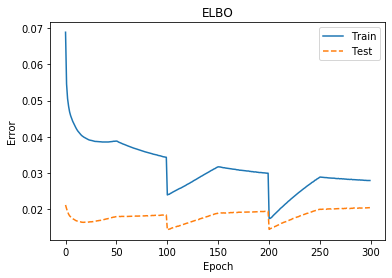

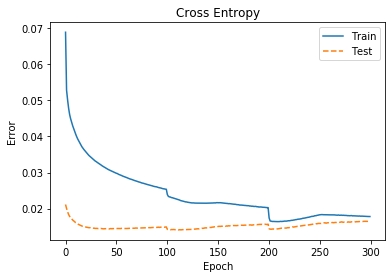

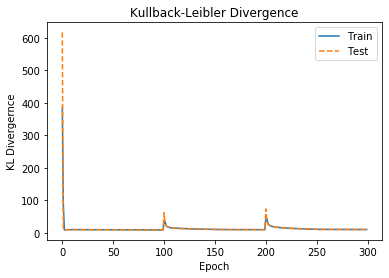

Epoch 299: time: 15.135177612304688
train: loss: 0.02790000411087456 BCE: 0.017794866114854813 KLD: 10.3446626663208
test: loss: 0.020394953601765183 BCE: 0.01652766391634941 KLD: 10.248316764831543


In [0]:
N_epochs = 600
N_train = len(training_data)
N_test = len(test_data)


train_loss_arr, train_bce_arr, train_kld_arr = [], [], []
test_loss_arr, test_bce_arr, test_kld_arr = [], [], []
for epoch in range(N_epochs//2):
    rnn_vae.train()
    start = time.time()

    train_loss, train_bce, train_kld = train(epoch)
    train_loss_arr.append(train_loss)
    train_bce_arr.append(train_bce)
    train_kld_arr.append(train_kld)

    test_loss, test_bce, test_kld = test(epoch)
    test_loss_arr.append(test_loss)
    test_bce_arr.append(test_bce)
    test_kld_arr.append(test_kld) 
    

    plot_loss(train_loss_arr, train_bce_arr, train_kld_arr,
              test_loss_arr, test_bce_arr, test_kld_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"train: loss: {train_loss} BCE: {train_bce} KLD: {train_kld}")
    print(f"test: loss: {test_loss} BCE: {test_bce} KLD: {test_kld}")
    clear_output(wait=True)

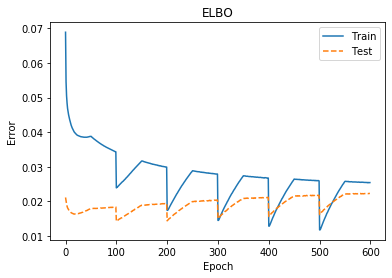

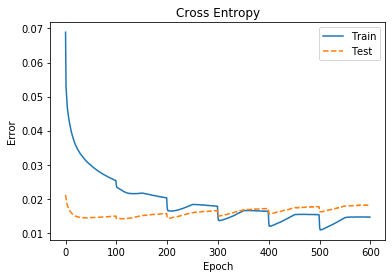

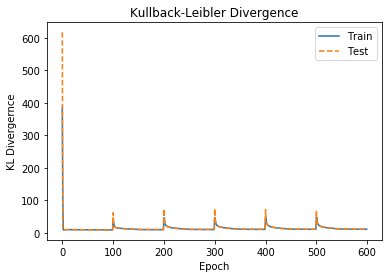

Epoch 599: time: 15.10148310661316
train: loss: 0.025435060047033727 BCE: 0.014612607657909393 KLD: 11.078975677490234
test: loss: 0.022300060919995576 BCE: 0.018160032108426094 KLD: 10.971078872680664


In [0]:
for epoch in range(N_epochs//2, N_epochs):
    rnn_vae.train()
    start = time.time()

    train_loss, train_bce, train_kld = train(epoch)
    train_loss_arr.append(train_loss)
    train_bce_arr.append(train_bce)
    train_kld_arr.append(train_kld)

    test_loss, test_bce, test_kld = test(epoch)
    test_loss_arr.append(test_loss)
    test_bce_arr.append(test_bce)
    test_kld_arr.append(test_kld) 
    

    plot_loss(train_loss_arr, train_bce_arr, train_kld_arr,
              test_loss_arr, test_bce_arr, test_kld_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"train: loss: {train_loss} BCE: {train_bce} KLD: {train_kld}")
    print(f"test: loss: {test_loss} BCE: {test_bce} KLD: {test_kld}")
    clear_output(wait=True)

#### save model

In [0]:
torch.save(rnn_vae.state_dict(), root_path + "trained_models/" + "FB_CA_WD_RNN_VAE_large.pt")

#### Optional load model

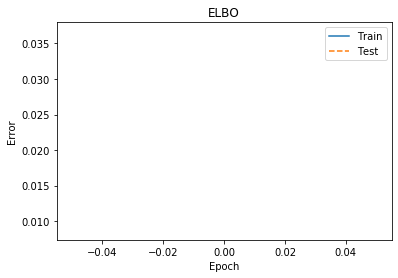

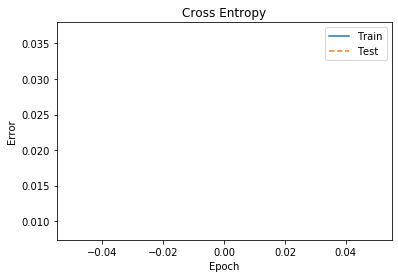

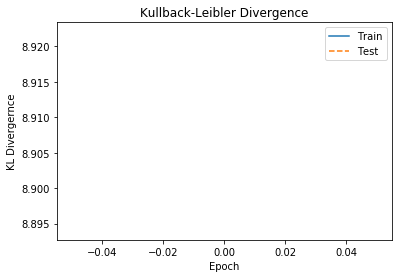

Epoch 0: time: 3.949347496032715
train: loss: 0.008775743111475363 BCE: 0.008775743655860424 KLD: 8.921988487243652
test: loss: 0.03657128638827924 BCE: 0.036571286618709564 KLD: 8.894110679626465


In [35]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
LATENT_DIM = 64

if (use_large_dataset == True) :
  BATCH_SIZE = 1024 
else:
  BATCH_SIZE = 2048

SEQ_LEN = 12 #padded + EOS + SOS
WORD_DROPOUT_P = 0.25

rnn_vae =  RNN_VAE(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                  latent_dim=LATENT_DIM, vocab_size=VOCAB_SIZE, seq_length=SEQ_LEN, word_dropout_p = WORD_DROPOUT_P).cuda()




if (use_large_dataset == True) :
  rnn_vae.load_state_dict(torch.load(root_path + "trained_models/" + "FB_CA_WD_RNN_VAE_large.pt"))
else:
  rnn_vae.load_state_dict(torch.load(root_path + "trained_models/" + "FB_CA_WD_RNN_VAE_small.pt"))

N_train = len(training_data)
N_test = len(test_data)


train_loss_arr, train_bce_arr, train_kld_arr = [], [], []
test_loss_arr, test_bce_arr, test_kld_arr = [], [], []
for epoch in range(1):
    rnn_vae.train()
    start = time.time()

    train_loss, train_bce, train_kld = train(epoch)
    train_loss_arr.append(train_loss)
    train_bce_arr.append(train_bce)
    train_kld_arr.append(train_kld)

    test_loss, test_bce, test_kld = test(epoch)
    test_loss_arr.append(test_loss)
    test_bce_arr.append(test_bce)
    test_kld_arr.append(test_kld) 
    

    plot_loss(train_loss_arr, train_bce_arr, train_kld_arr,
              test_loss_arr, test_bce_arr, test_kld_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"train: loss: {train_loss} BCE: {train_bce} KLD: {train_kld}")
    print(f"test: loss: {test_loss} BCE: {test_bce} KLD: {test_kld}")
    clear_output(wait=True)

# Model evaluation

#### ELBO, CBE and KL Divergence of trained model

In [36]:
print(f"ELBO \nTrain: {train_loss_arr[-1]} Test: {test_loss_arr[-1]}")
print(f"Cross Entropy \nTrain: {train_bce_arr[-1]} Test: {test_bce_arr[-1]}")
print(f"KL Divergence \nTrain: {train_kld_arr[-1]} Test: {test_kld_arr[-1]}")

ELBO 
Train: 0.008775743111475363 Test: 0.03657128638827924
Cross Entropy 
Train: 0.008775743655860424 Test: 0.036571286618709564
KL Divergence 
Train: 8.921988487243652 Test: 8.894110679626465


In [37]:
active_units, test_vars = getActiveUnits(rnn_vae, test_data_loader, delta=0.02)
print(f"Active units: {active_units.cpu().numpy()}")
print(f"Variances: \n{test_vars.cpu().detach().numpy()}")

Active units: 64
Variances: 
[[0.18557668 0.21480191 0.21227585 0.18736768 0.21037252 0.20832033
  0.21541244 0.20022424 0.17347924 0.18579283 0.1832879  0.2049855
  0.18819067 0.21608703 0.21601465 0.21573512 0.17469978 0.21235637
  0.20739044 0.17358333 0.2116528  0.21577114 0.7844413  0.17314476
  0.21362193 0.2049775  0.2062326  0.17926289 0.1884649  0.21037729
  0.17320648 0.20967704 0.20553787 0.21004048 0.1851343  0.21748072
  0.18798931 0.20968309 0.18322754 0.12510899 0.20036215 0.20193847
  0.19921458 0.18404801 0.11758181 0.20979907 0.3111816  0.21288052
  0.2112756  0.21718091 0.18502218 0.18316765 0.19097988 0.21014942
  0.2155115  0.17228268 0.12518468 0.21041478 0.21107565 0.18433627
  0.21698776 0.21100451 0.21067725 0.18750487]]


#### reconstructing sentences from training set

In [0]:
for i in range(10):
  print_generative_reconstruction(rnn_vae=rnn_vae, sp=sp, sentence_in_batch=i, train_data_loader=train_data_loader)
  print('*******')

Real sentence: i know amy lee and love her.
Generated sentence: i say 10,000 fists over the sickness.

*******
Real sentence: i think your name says it all.
Generated sentence: i considered that we are lucky lucky.

*******
Real sentence: i will give it to you very shortly.
Generated sentence: i will choose whatever the answer later.

*******
Real sentence: i have hdtv and is awesome.
Generated sentence: he is a detestable person does.

*******
Real sentence: that he does'nt want to talk about.
Generated sentence: i do not know, but i hope not.

*******
Real sentence: i hope it works out for you.
Generated sentence: i am still trying to figure out myself.

*******
Real sentence: you might even ask her out then!
Generated sentence: is it you have to be done?

*******
Real sentence: i would kick both of their a**.
Generated sentence: i cannot wait for any trouble my life.

*******
Real sentence: would you dance if i asked you to dance?
Generated sentence: first off...they do and need to 

#### reconstructing sentences from test set

In [0]:
for i in range(10):
  print_generative_reconstruction(rnn_vae=rnn_vae, sp=sp, sentence_in_batch=i, train_data_loader=test_data_loader)
  print('*******')

Real sentence: are you posing a rhetorical question?
Generated sentence: are you talkin about that guy?

*******
Real sentence: i do not intend to be mean.
Generated sentence: i do not know but maybe im not.

*******
Real sentence: ask him if you should go see a doctor.
Generated sentence: teach them how deep murphy, and do. you

*******
Real sentence: also, i would like to try again.
Generated sentence: although, if you really need to know.

*******
Real sentence: women are coomplicated.
Generated sentence: tone 80 music it.

*******
Real sentence: doing that does sound rather feminine.
Generated sentence: john does not have any children.

*******
Real sentence: do i desire to be in love?
Generated sentence: did he urinate on them as well?

*******
Real sentence: that is if you truly adore them.
Generated sentence: that is where i see it.

*******
Real sentence: you should never allow a man to mistreat you.
Generated sentence: you should not marry your crush out her.

*******
Real sen